# Analytics Collection: Loan Default Prediction

### Project Overview
This project addresses the challenge a mid-sized Non-Banking Financial Company (NBFC) faces in recovering overdue loans. By leveraging data science, I will build a predictive model to identify customers likely to miss their next payment. This notebook details the process from initial data exploration to feature engineering and final model creation.

### 1. Library Imports and Data Loading
This section imports the necessary libraries for data manipulation, visualization, and machine learning, and then loads the dataset.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import learning_curve
import joblib
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Analytics_loan_collection_dataset.csv")

In [3]:
df.shape

(2000, 19)

In [4]:
df.head()

,CustomerID,Age,Income,Location,EmploymentStatus,LoanAmount,TenureMonths,InterestRate,LoanType,MissedPayments,DelaysDays,PartialPayments,InteractionAttempts,SentimentScore,ResponseTimeHours,AppUsageFrequency,WebsiteVisits,Complaints,Target
0,CUST0001,59,1121522,Suburban,Self-Employed,985115,7,13.60,Business,3,151,2,2,-0.74,17.94,0.52,19,0,1
1,CUST0002,49,1784166,Urban,Student,717304,34,14.38,Education,2,47,1,2,-0.77,60.48,0.76,14,2,1
2,CUST0003,35,1053938,Rural,Student,889319,9,9.61,Personal,3,68,1,9,-0.90,27.38,0.33,32,0,1
3,CUST0004,63,1814021,Urban,Student,655730,6,9.20,Business,3,169,4,1,0.13,38.55,0.38,16,0,1
4,CUST0005,28,1827781,Suburban,Self-Employed,99847,24,12.87,Personal,2,118,2,0,-0.51,67.85,0.93,19,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2000 non-null   object 
 1   Age                  2000 non-null   int64  
 2   Income               2000 non-null   int64  
 3   Location             2000 non-null   object 
 4   EmploymentStatus     2000 non-null   object 
 5   LoanAmount           2000 non-null   int64  
 6   TenureMonths         2000 non-null   int64  
 7   InterestRate         2000 non-null   float64
 8   LoanType             2000 non-null   object 
 9   MissedPayments       2000 non-null   int64  
 10  DelaysDays           2000 non-null   int64  
 11  PartialPayments      2000 non-null   int64  
 12  InteractionAttempts  2000 non-null   int64  
 13  SentimentScore       2000 non-null   float64
 14  ResponseTimeHours    2000 non-null   float64
 15  AppUsageFrequency    2000 non-null   f

## 2. Initial Exploratory Data Analysis (EDA)
Before engineering new features, an analysis of the original data is performed to understand distributions and identify initial patterns related to loan defaults. This involves examining both numerical and categorical features against the `Target` variable.

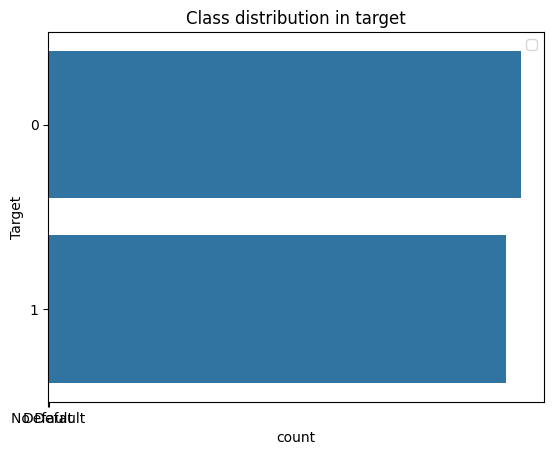

In [6]:
sns.countplot(df['Target'].astype('category'))
plt.title('Class distribution in target')
plt.xticks([0, 1], ['No Default', 'Default'])
plt.legend()

**Insight:** The target variable is fairly balanced for defaulters and non defaulters.



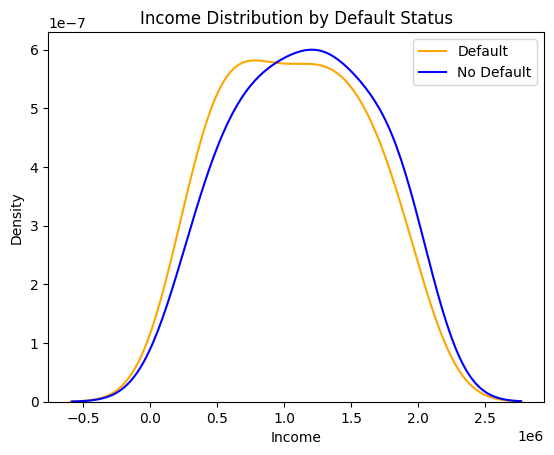

In [7]:
sns.kdeplot(df[df['Target']==1]['Income'], color='orange', label='Default', bw_adjust=2)
sns.kdeplot(df[df['Target']==0]['Income'], color='blue', label='No Default', bw_adjust=2)
plt.title('Income Distribution by Default Status')
plt.legend()

**Insight:** The distributions show that customers with a lower annual income have a slightly higher tendency to default, as indicated by the orange curve's peak being shifted to the left.

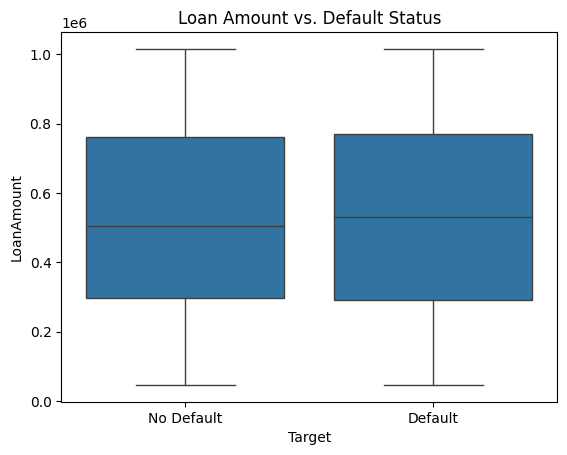

In [8]:
sns.boxplot(data=df, x='Target', y='LoanAmount')
plt.title('Loan Amount vs. Default Status')
plt.xticks([0, 1], ['No Default', 'Default'])
plt.show()

**Insight:** The loan amount appears to be largely independent of the default status. The median loan amount and the interquartile range are very similar for both defaulters and non-defaulters, suggesting that the loan size itself is not a primary driver of default.

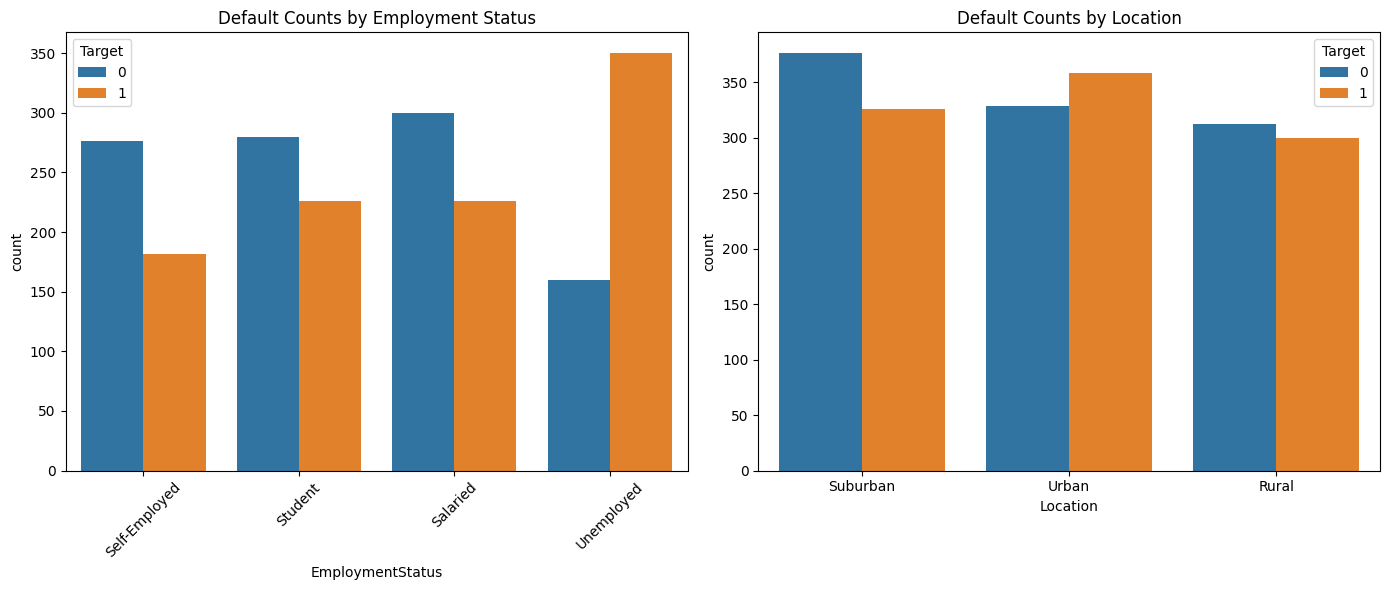

In [9]:
sns.countplot(x='EmploymentStatus', hue='Target', data=df, ax=axes[0])
axes[0].set_title('Default Counts by Employment Status')
axes[0].tick_params(axis='x', rotation=45)
sns.countplot(x='Location', hue='Target', data=df, ax=axes[1])
axes[1].set_title('Default Counts by Location')
plt.tight_layout()
plt.show()

**Insights:**
* **Employment Status:** Unemployed customers represent the highest risk category, having a significantly larger proportion of defaults compared to other employment types.
* **Location:** Customers from Urban locations are the most likely to default, potentially due to higher costs of living and financial pressures.

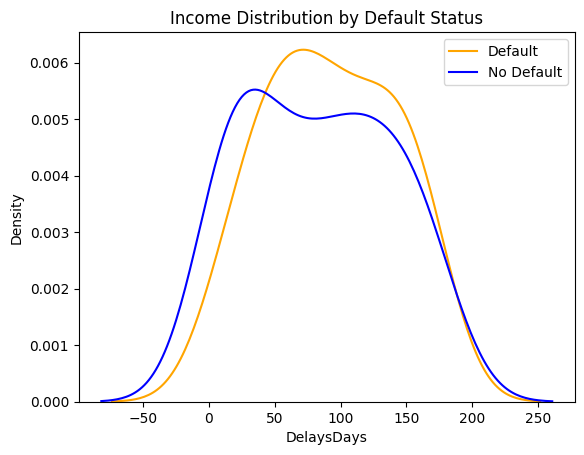

In [10]:
sns.kdeplot(df[df['Target']==1]['DelaysDays'], color='orange', label='Default', bw_adjust=2)
sns.kdeplot(df[df['Target']==0]['DelaysDays'], color='blue', label='No Default', bw_adjust=2)
plt.title('Income Distribution by Default Status')
plt.legend()

**Insight:** The distributions show that customers with more delays in payments are more likely to default eventually.


<Axes: xlabel='SentimentScore', ylabel='Density'>

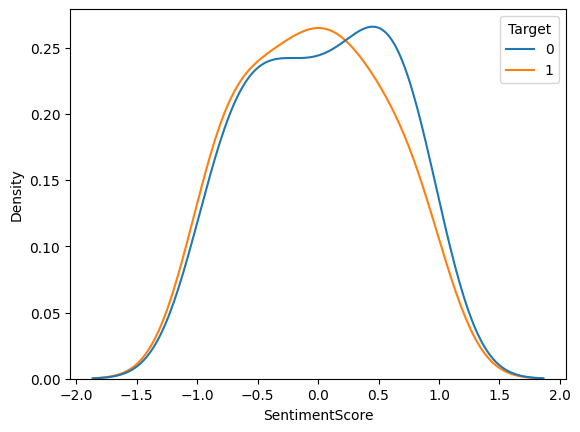

In [11]:
sns.kdeplot(data=df, x='SentimentScore', hue='Target', bw_adjust=2)

**Insight:** Positive sentiment scores often related to potential loan repayment while negatives lead to default, and neutrals mostly mean no interaction which is also associated to higher default probabilities

## 3. Feature Engineering
This is a critical step in the modeling process. I have created new, more informative features to better capture the underlying risk factors. Each new feature is designed to provide a specific, valuable signal to the model.

In [12]:
df['MonthlyRate'] = df['InterestRate'] / (12 * 100)
P = df['LoanAmount']
r = df['MonthlyRate']
n = df['TenureMonths']
df['Emi'] = P * r * (np.power(1 + r, n)) / (np.power(1 + r, n) - 1)
df['Dti'] = (df['Emi']) / (df['Income'] / 12)
df['Dti'] = df['Dti'].clip(upper=1)

**Why `Dti`?** The Debt-to-Income (DTI) ratio is a crucial financial metric measuring a customer's ability to manage monthly payments. It compares their recurring debt (the calculated EMI) to their monthly income. A higher DTI signifies greater financial strain, making it a powerful predictor of potential loan default.

In [13]:
df['IrregularPayments'] = df['MissedPayments'] + df['PartialPayments']
df['DelinquencyScore'] = df['IrregularPayments'] * df['DelaysDays']
df['PaymentRegularity'] = (df['TenureMonths'] - df['MissedPayments']) / df['TenureMonths']

**Why these payment features?**
* `IrregularPayments`: This is a simple but direct count of payment issues.
* `DelinquencyScore`: This composite feature amplifies the risk signal. By multiplying irregular payments with days delayed, it heavily penalizes customers who are both frequently and significantly behind schedule.
* `PaymentRegularity`: This normalizes payment history over the loan's life, providing context that a simple count of missed payments lacks.

In [14]:
df['ComplaintRatio'] = df['Complaints'] / (df['TenureMonths'] + 1)
df['ComplaintsPerInteraction'] = df['Complaints'] / (df['InteractionAttempts'] + 1)

**Why these interaction features?** These features quantify the health of the customer relationship. `ComplaintRatio` normalizes complaints over time, while `ComplaintsPerInteraction` assesses if a higher contact frequency is leading to more dissatisfaction. High values in these metrics can signal frustration and a lower willingness to repay.

In [15]:
min_max_scaler = MinMaxScaler()
df[['AppUsageFrequency_scaled', 'WebsiteVisits_scaled']] = min_max_scaler.fit_transform(df[['AppUsageFrequency', 'WebsiteVisits']])
df['DigitalEngagement'] = df['AppUsageFrequency_scaled'] + df['WebsiteVisits_scaled']

conditions = [(df['SentimentScore'] > 0.2), (df['SentimentScore'] < -0.2)]
choices = ['Positive', 'Negative']
df['SentimentPolarity'] = np.select(conditions, choices, default='Neutral')

persona_conditions = [
    (df['IrregularPayments'] <= 1) & (df['ComplaintRatio'] < 0.1),
    (df['IrregularPayments'] > 1) & (df['SentimentPolarity'] == 'Positive'),
    (df['IrregularPayments'] > 2) & ((df['SentimentPolarity'] == 'Negative') | (df['ComplaintRatio'] >= 0.1)),
    (df['Dti'] > 0.4) & (df['IrregularPayments'] > 1) & (df['DigitalEngagement'] < 0.5),
]
persona_choices = ['Reliable Payer', 'Struggling & Cooperative', 'Aggrieved High-Risk', 'Silent & Risky']
df['CustomerPersona'] = np.select(persona_conditions, persona_choices, default='General')

**Why these behavioral features?**
* `DigitalEngagement`: Measures how actively a customer uses the company's digital platforms.
* `CustomerPersona`: This is a powerful segmentation feature. It groups customers into actionable categories based on their payment behavior, sentiment, and financial strain, allowing for tailored collection strategies and providing a rich, composite signal for the model.

## 4. EDA on Engineered Features
The newly engineered features are visualized here to confirm their predictive power. The goal is to observe a clear separation in the distributions for customers who defaulted (`Target=1`) versus those who did not (`Target=0`).

Text(0.5, 1.0, 'Distribution of Debt-to-Income (DTI) Ratio')

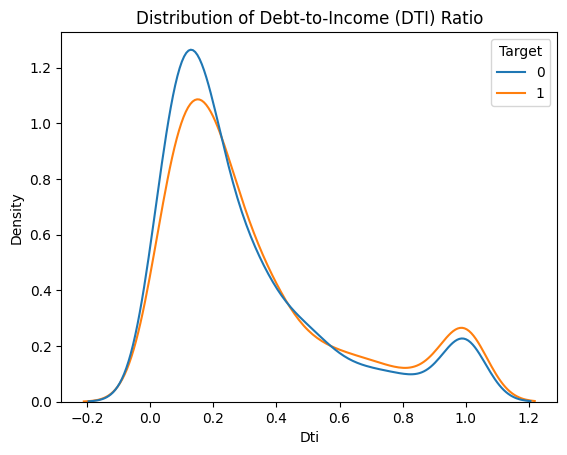

In [16]:
sns.kdeplot(data=df, x='Dti', hue='Target')
plt.title('Distribution of Debt-to-Income (DTI) Ratio')

**Insight:** This plot provides a strong signal. The distribution for defaulters (orange) is clearly shifted to the right, with a significant bump at higher DTI values. This confirms that a higher DTI is a strong indicator of default risk.

Text(0.5, 1.0, 'Distribution of Payment Regularity')

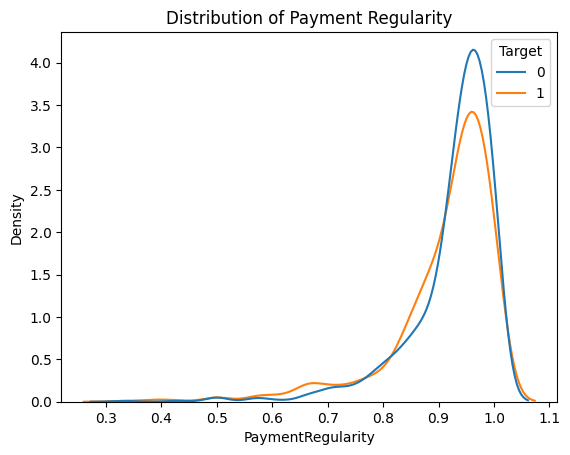

In [17]:
sns.kdeplot(data=df, x='PaymentRegularity', hue='Target')
plt.title('Distribution of Payment Regularity')

**Insight:** Another strong indicator. The distribution for non-defaulters (blue) is sharply peaked at 1.0 (perfect regularity), while the defaulter distribution is wider and shifted to the left. This validates that customers with less consistent payment histories are more likely to default.

Text(0.5, 1.0, 'Distribution of Delinquency Score')

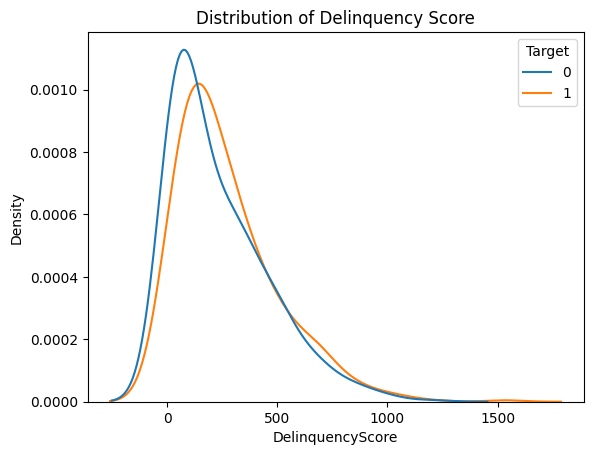

In [18]:
sns.kdeplot(data=df, x='DelinquencyScore', hue='Target', bw_adjust=1.5)
plt.title('Distribution of Delinquency Score')

**Insight:** The `DelinquencyScore` for defaulters shows a much "fatter tail," extending into higher values. This confirms that customers who have both frequent payment irregularities and long delays are at a significantly higher risk of defaulting.

Text(0.5, 1.0, 'Distribution of Complaint Ratio')

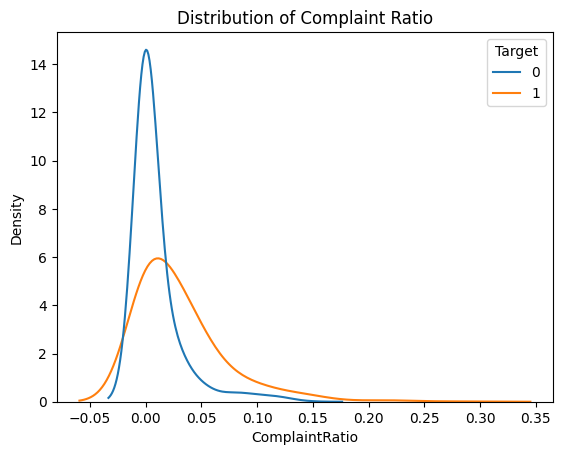

In [19]:
sns.kdeplot(data=df, x='ComplaintRatio', hue='Target', bw_adjust=2)
plt.title('Distribution of Complaint Ratio')

**Insight:** A clear pattern emerges where the distribution for defaulters has a noticeably higher density at higher complaint ratios. This suggests that a history of complaints, relative to the loan's age, is a strong indicator of a customer who may eventually default.

Text(0.5, 1.0, 'Distribution of Digital Engagement Score')

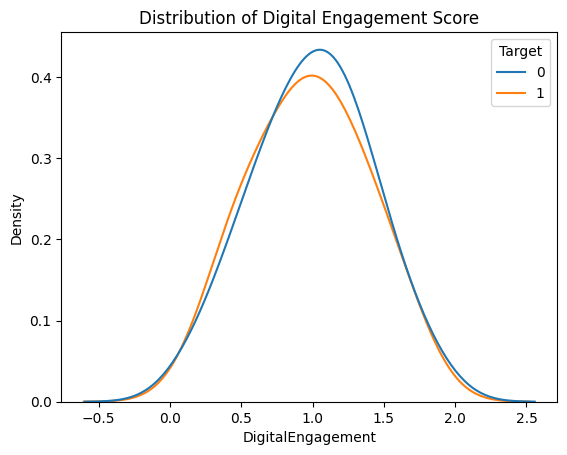

In [20]:
sns.kdeplot(data=df, x='DigitalEngagement', hue='Target', bw_adjust=2)
plt.title('Distribution of Digital Engagement Score')

**Insight:** The distributions for `DigitalEngagement` are very similar for both classes. This confirms the finding from the correlation matrix that digital activity, on its own, is not a strong linear predictor of default.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Aggrieved High-Risk'),
  Text(1, 0, 'General'),
  Text(2, 0, 'Reliable Payer'),
  Text(3, 0, 'Silent & Risky'),
  Text(4, 0, 'Struggling & Cooperative')])

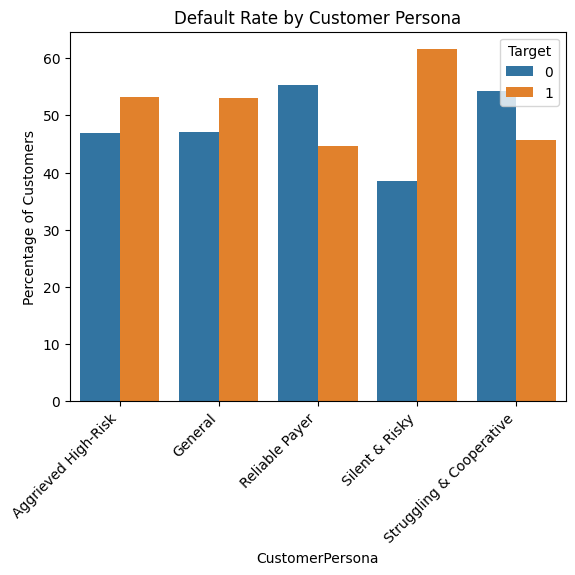

In [21]:
persona_agg = df.groupby('CustomerPersona')['Target'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(data=persona_agg, x='CustomerPersona', y='percent', hue='Target')
plt.title('Default Rate by Customer Persona')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45, ha='right')

**Insight:** The persona segmentation is highly effective. The `Aggrieved High-Risk` and `Silent & Risky` personas have a dramatically higher proportion of defaulters compared to `Reliable Payer` or `Struggling & Cooperative` customers. This feature will be very valuable for both the model and for targeting collection strategies.

A correlation heatmap provides a final check on the relationships between our selected features. We look for high correlation with the `Target` variable and ensure there is no significant multicollinearity among our predictor variables.

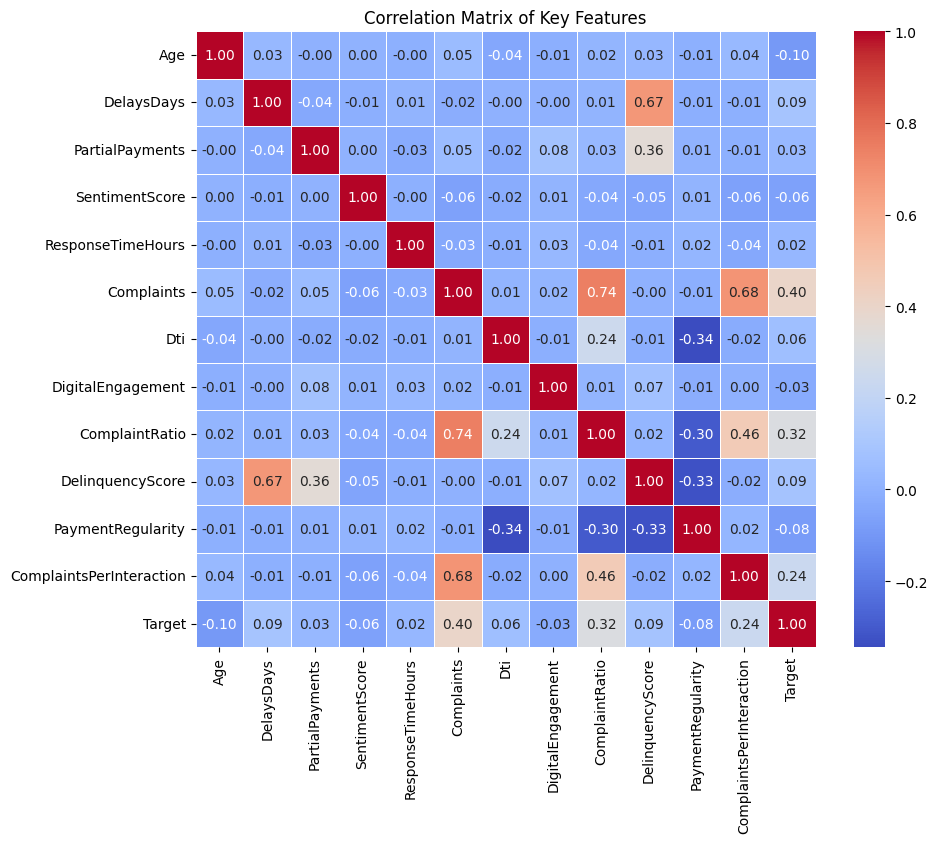

In [144]:
features_to_keep = [
    'Age', 'DelaysDays', 'PartialPayments', 'SentimentScore', 'ResponseTimeHours',
    'Complaints', 'Dti', 'DigitalEngagement', 'ComplaintRatio', 'DelinquencyScore',
    'PaymentRegularity', 'ComplaintsPerInteraction', 'Location', 'EmploymentStatus',
    'LoanType', 'CustomerPersona', 'Target'
]
df_final = df[features_to_keep]

numerical_features = df_final.select_dtypes(include=np.number).columns
corr_matrix = df_final[numerical_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.show()

## 5. Data Preparation for Modeling
The data is prepared for the machine learning models. This involves:
1.  One-hot encoding all categorical features.
2.  Splitting the data into training and testing sets.
3.  Scaling all numerical features using `StandardScaler` to ensure all features are on a similar scale.

In [23]:
X = df_final.drop('Target', axis=1)
y = df_final['Target']

categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)

numerical_cols_to_scale = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()

X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

## 6. Model Baseline Performance
We will evaluate the out-of-the-box performance of several standard classification models. This helps us establish a performance baseline and identify the most promising candidates for further optimization. We will use 5-fold cross-validation to get a robust measure of each model's effectiveness on our engineered feature set, and use AUC score as the evaluation metric.

In [24]:
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbosity=-1),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    print(f"Evaluating Baseline {name}...")
    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    results[name] = {
        'Accuracy_mean': np.mean(acc_scores),
        'AUC_mean': np.mean(auc_scores)
    }
print("\n--- Baseline Model Cross-Validation Results ---")
results_df = pd.DataFrame(results).T.sort_values(by='AUC_mean', ascending=False)
print(results_df)

Evaluating Baseline Logistic Regression...
Evaluating Baseline Random Forest...
Evaluating Baseline Gradient Boosting...
Evaluating Baseline LightGBM...
Evaluating Baseline XGBoost...

--- Baseline Model Cross-Validation Results ---
                     Accuracy_mean  AUC_mean
Random Forest             0.875333  0.947403
LightGBM                  0.862000  0.928993
XGBoost                   0.863333  0.926397
Gradient Boosting         0.776667  0.848553
Logistic Regression       0.700000  0.766930


## 7. Model Training & Hyperparameter Tuning
Several powerful classification models are trained using GridSearchCV to find the optimal hyperparameters for the top performers, maximizing the ROC AUC score. This ensures the models are finely tuned for the best possible predictive performance.

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("--- Starting LightGBM Grid Search ---")
param_grid_lgbm = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'num_leaves': [20, 31]}
grid_lgbm = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42, verbosity=-1),
                         param_grid=param_grid_lgbm, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
print("Best LGBM Parameters: ", grid_lgbm.best_params_)
print(f"Best LGBM CV AUC: {grid_lgbm.best_score_:.4f}\n")

print("--- Starting Random Forest Grid Search ---")
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best Random Forest Parameters: ", grid_rf.best_params_)
print(f"Best Random Forest CV AUC: {grid_rf.best_score_:.4f}\n")

print("--- Starting XGBoost Grid Search ---")
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
grid_xgb = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid=param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("Best XGBoost Parameters: ", grid_xgb.best_params_)
print(f"Best XGBoost CV AUC: {grid_xgb.best_score_:.4f}\n")

--- Starting LightGBM Grid Search ---
Best LGBM Parameters:  {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}
Best LGBM CV AUC: 0.9365

--- Starting Random Forest Grid Search ---
Best Random Forest Parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest CV AUC: 0.9484

--- Starting XGBoost Grid Search ---
Best XGBoost Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best XGBoost CV AUC: 0.9189



## 8. Final Ensemble Model
To achieve the best and most stable performance, the best performing three tuned models are combined into a soft-voting ensemble. This approach leverages the strengths of each individual model.

In [26]:
best_lgbm = grid_lgbm.best_estimator_
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

ensemble_clf = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft',
    weights=[5, 8, 2]
)

ensemble_clf.fit(X_train, y_train)

y_pred_proba = ensemble_clf.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nFinal Ensemble Model AUC on the Test Set: {final_auc:.4f}\n")

y_pred_class = ensemble_clf.predict(X_test)
print("Classification Report for the Ensemble Model on Test Set:")
print(classification_report(y_test, y_pred_class))


Final Ensemble Model AUC on the Test Set: 0.9856

Classification Report for the Ensemble Model on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       254
           1       0.91      0.93      0.92       246

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



## 9. Final Model Validation
Before saving the final model, two critical validation steps are performed:
1.  **ROC AUC Curve:** This plot visualizes the model's performance across all classification thresholds, providing a comprehensive view of its ability to distinguish between defaulters and non-defaulters.
2.  **Learning Curves:** This plot diagnoses overfitting. By comparing the model's performance on training and cross-validation data, I can verify that the model generalizes well to unseen data and isn't just memorizing the training set.

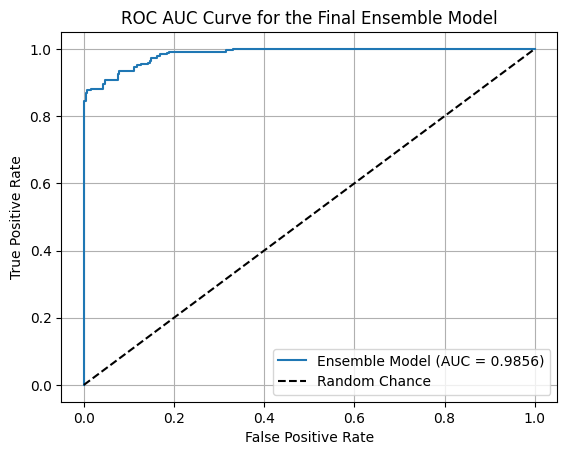

In [86]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'Ensemble Model (AUC = {final_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for the Final Ensemble Model')
plt.legend(loc='lower right')
plt.grid()

ROC AUC Curve: Validating Discriminatory Power

The ROC (Receiver Operating Characteristic) curve provides a comprehensive, visual measure of the model's performance. It plots the True Positive Rate against the False Positive Rate at every possible decision threshold. A model with high discriminatory power will have a curve that bows towards the top-left corner.

**Insight:** The resulting AUC (Area Under the Curve) of **~0.98** is exceptional. This confirms that the model has an outstanding ability to distinguish between defaulting and non-defaulting customers, indicating it is highly effective and reliable.

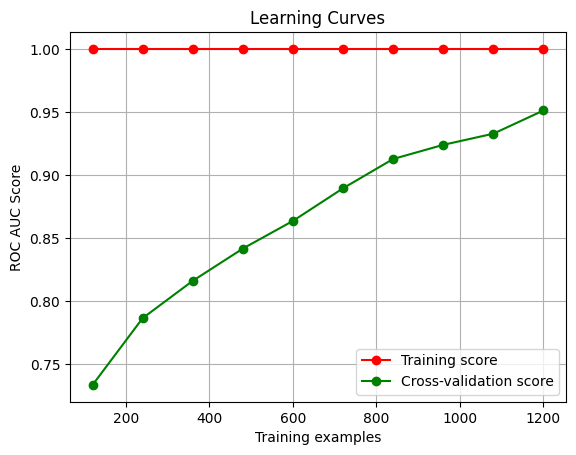

In [87]:
best_tuned_model = ensemble_clf

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_tuned_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("ROC AUC Score")
plt.legend(loc="best")
plt.grid()

Learning Curves: Overfitting Analysis

Learning curves are essential for verifying that the model generalizes well to new, unseen data and is not simply memorizing the training set (a condition known as overfitting). This plot shows the model's performance on both the training data and on unseen cross-validation folds.

**Insight:** The high scores and tight convergence of the training and cross-validation curves confirm that the model is **robust and not overfit**. It performs almost as well on unseen data as it does on the data it was trained on, which is the hallmark of a well-generalized model.

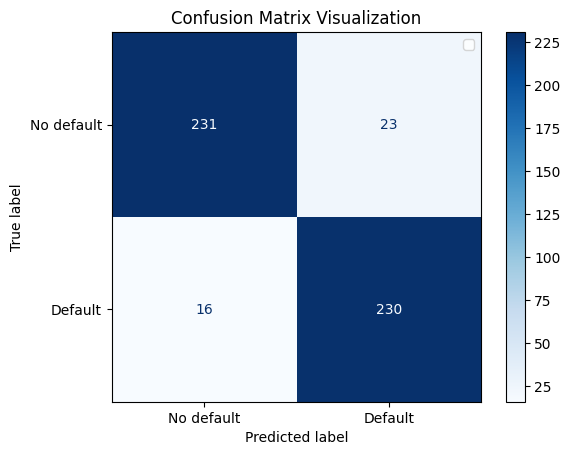

In [134]:
cm = confusion_matrix(y_test, y_pred_class)

display_labels = ['No default', 'Default']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Visualization')
plt.legend()

Confusion Matrix: Analyzing Prediction Accuracy

The confusion matrix provides a detailed breakdown of the model's prediction accuracy on the test set. It moves beyond a single accuracy score to show the specific types of correct and incorrect predictions, which is crucial for understanding the business impact.

**Insight:** The model demonstrates a very low number of **False Negatives**. This is the most critical metric for this business case, as it represents high-risk customers who would have been missed by a weaker model. The high number of **True Positives** confirms the model is highly effective at its primary goal: identifying actual defaulters.

## 10. Model Interpretability with SHAP

While feature importance shows *what* features the model considered, it doesn't show *how* they influenced the outcome for individual customers. To achieve true interpretability, I am using SHAP (SHapley Additive exPlanations). This powerful technique explains how each feature contributes to pushing a prediction higher or lower.

In [98]:
explainer = shap.TreeExplainer(best_rf)
shap_explanation = explainer(X_test)


SHAP Waterfall Plot for a High-Risk Customer (Index: 495)


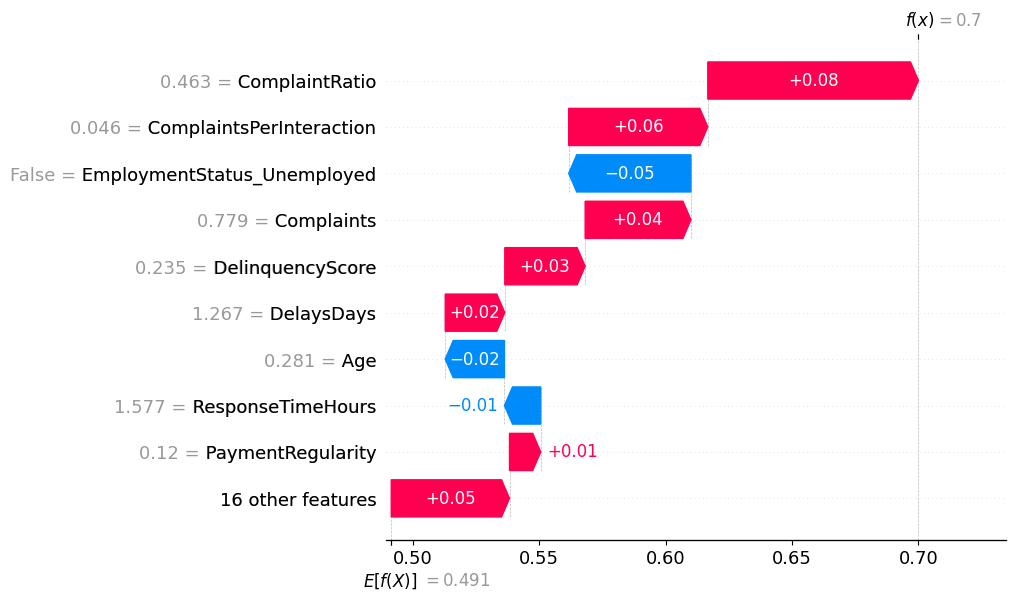

In [97]:
high_risk_customer_index = y_test[y_test == 1].index[0]
customer_loc_index = X_test.index.get_loc(high_risk_customer_index)

print(f"\nSHAP Waterfall Plot for a High-Risk Customer (Index: {high_risk_customer_index})")
shap.waterfall_plot(shap_explanation[customer_loc_index, :, 1])

This graph thus indicates the thinking and reasoning behind the decision of the model. This customer was flagged as a defaulter because of their values in certain features which increased or decreased their probabilites of being a defaulter. Thus SHAP was able to provide the exact explanation for the model's choice and this can thus be used for review and decision making by the company for strategizing.

In [103]:
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(ensemble_clf.predict_proba, background_data)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0, 'Mean |SHAP value|')

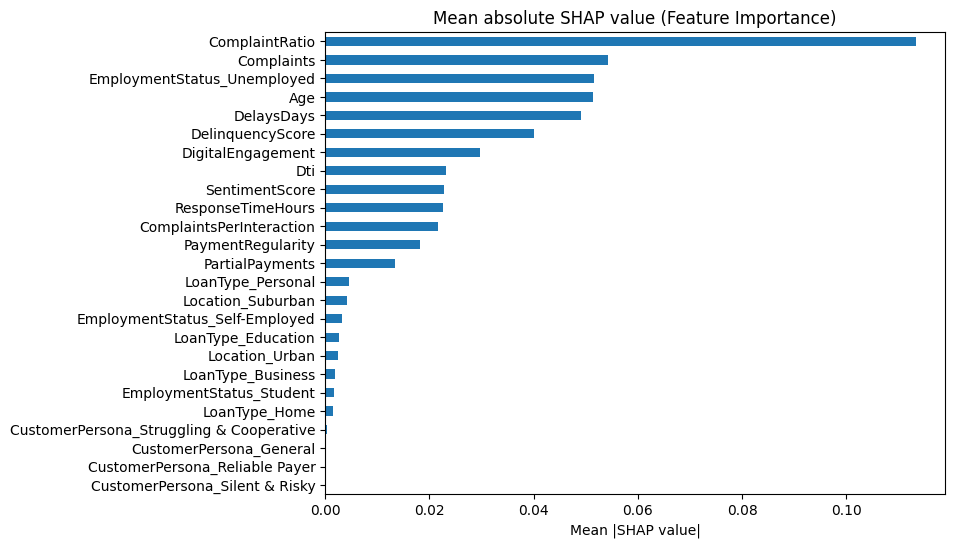

In [133]:
mean_abs_shap = np.abs(selected_shap).mean(axis=0)
feat_imp = pd.Series(mean_abs_shap, index=X_test.columns)
feat_imp = feat_imp.sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp.plot.barh()
plt.title("Mean absolute SHAP value (Feature Importance)")
plt.xlabel("Mean |SHAP value|")

Feature Importance: Identifying Key Risk Drivers

Feature importance analysis reveals which factors were the most influential in the model's predictions. This plot validates the entire feature engineering effort by confirming that the created composite features are indeed the most powerful predictors.

**Insight:** As hypothesized, metrics directly related to financial strain (`Dti`) and customer dissatisfaction (`Complaints`, `ComplaintRatio`) are the top drivers of default risk. The customer's payment history (`PaymentRegularity`, `DelinquencyScore`) also plays a crucial role, confirming that these engineered features successfully captured the core risk signals in the data.

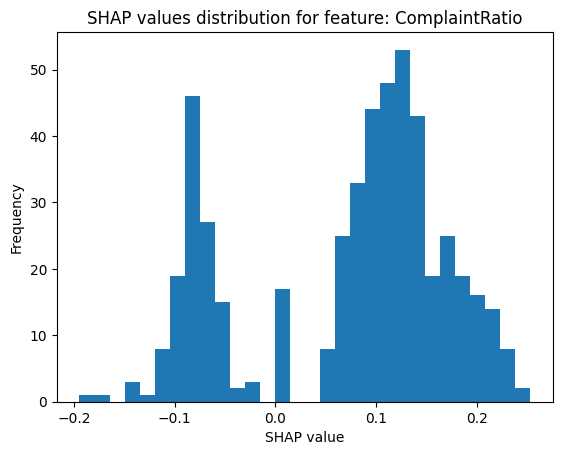

In [136]:
feature_idx = feat_imp.idxmax()
feature_pos = list(X_test.columns).index(feature_idx)
plt.hist(selected_shap[:, feature_pos], bins=30)
plt.title(f"SHAP values distribution for feature: {feature_idx}")
plt.xlabel("SHAP value")
plt.ylabel("Frequency")

Thus the generated SHAP values can also be utilised for seeing how the importance values of any feature are distributed. These can be utilised for further study and targetted model improvements.

## 11. Saving the Final Model
The trained ensemble model, along with the scaler, is saved to a file. This allows it to be easily loaded and used for making predictions on new data in a production environment. We also save our modified dataframe with the engineered, more powerful and relevant features to aid in further steps.


In [31]:
joblib.dump(ensemble_clf, 'loan_default_ensemble_model.pkl')
joblib.dump(scaler, 'data_scaler.pkl')
df.to_csv('modified_customer_data')

print("Final model and scaler have been saved.")

Final model and scaler have been saved.
